In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from kmodes.kmodes import KModes   # 범주형 DF를 다룰수 있는 kmean모델
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 1. 데이터 불러오기

In [2]:
label_df = pd.read_csv("라벨인코딩결과.csv")
df = pd.read_csv("룸메이트_설문지결과.csv")

df['age'] = df['age']%10
df['age'] = df['age'].astype(object)
#df.info()

In [3]:
# null 데이터 제거
df = df.dropna()
label_df = label_df.dropna()

In [4]:
# df 열 확인
df.columns
print(f"feature 개수: {len(df.columns)}")
print(f"데이터 개수: {len(df)}")

feature 개수: 34
데이터 개수: 191


# 2. 데이터 전처리

In [5]:
df_email = df['email']    # 기존 이메일 정보 저장

df = df.iloc[:, 2:]
label_df = label_df.iloc[:, 1:]

df.head()

,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,...,w_smoke,w_alchol,w_how_eat,w_how_eat_in,w_wake_up,w_sleep,w_sleep_sensitive,w_sleep_habit,w_clean_period,w_shower_timezone
0,남자,7,레이크홀,융합과학기술원,E(외향),주로 기숙사 밖,주로 기숙사 내,비흡연자,드물게,기숙사 식당,...,비흡연,드물게,기숙사 식당,희망,상관 없음,2시 이후,둔감,없다,0회~1회,아침
1,남자,1,레이크홀,문과대,E(외향),주로 기숙사 내,주로 기숙사 내,흡연자,자주,기숙사 내,...,흡연,상관 없음,기숙사 식당,비희망,8시~10시,상관 없음,예민,있다,2회~4회,상관 없음
2,남자,0,레이크홀,경영대,I(내향),주로 기숙사 밖,주로 기숙사 내,비흡연자,드물게,기숙사 밖,...,상관 없음,상관 없음,기숙사 밖,비희망,상관 없음,상관 없음,둔감,상관 없음,0회~1회,상관 없음
3,남자,5,비레이크홀,기타,I(내향),주로 기숙사 내,주로 기숙사 내,비흡연자,드물게,기숙사 내,...,비흡연,드물게,기숙사 밖,희망,상관 없음,상관 없음,둔감,없다,2회~4회,아침
4,여자,1,레이크홀,공과대,I(내향),주로 기숙사 밖,주로 기숙사 내,비흡연자,보통,기숙사 밖,...,비흡연,상관 없음,기숙사 밖,상관 없음,8시~10시,12시~2시,둔감,없다,상관 없음,상관 없음


In [6]:
label_df.head()  # 라벨 인코딩 되어있는 상태  -> [상관없음은 0으로 통일]

,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,...,w_smoke,w_alchol,w_how_eat,w_how_eat_in,w_wake_up,w_sleep,w_sleep_sensitive,w_sleep_habit,w_clean_period,w_shower_timezone
0,1,7,1,11,1,2,1,1,1,3,...,1,1,3,2,0,3,1,1,1,1
1,1,1,1,4,1,1,1,2,3,1,...,2,0,3,1,2,0,2,2,2,0
2,1,0,1,1,2,2,1,1,1,2,...,0,0,2,1,0,0,1,0,1,0
3,1,5,2,3,2,1,1,1,1,1,...,1,1,2,2,0,0,1,1,2,1
4,2,1,1,2,2,2,1,1,2,2,...,1,0,2,0,2,2,1,1,0,0


# 3. 데이터 변환
## 3-1 라벨 인코딩 데이터 생성
* 우리가 정한 순서대로 라벨인코딩

In [7]:
# 엑셀로 변환 했지만 임시로 만들어둠 (라벨 순서)
label_names = [["남자", "여자"], ["레이크홀", "비레이크홀"], ["문과대", "이과대", "건축대", "공과대", "사회과학대", "경영대", "부동산대",
                "융합과학기술원", "생명과학대", "수의대", "예술디자인대", "사범대", "기타"], ["E(외향)", "I(내향)"], ["주로 기숙사 내", "주로 기숙사 밖"], 
               ["주로 기숙사 내", "주로 기숙사 밖"], ["비흡연자", "흡연자"], ["드물게", "보통", "자주"], ["기숙사 내", "기숙사 밖", "기숙사 식당"],
               ["비희망", "희망"], ["6시~8시", "8시~10시", "10시~12시", "12시 이후"], ["10시~12시", "12시~2시", "2시 이후"],
               ["둔감", "예민"], ["없다", "있다", "잘모르겠다"], ["0회~1회", "2회~4회", "5회~7회"], ["아침", "저녁"], 
               ["20살~21살", "22살~23살", "24살~25살", "26살 이상", "상관 없음"]]

## 3-2 feature별 가중치 설정

In [8]:
# 데이터 프레임에 가중치 부여 -> 우리가 정한 가중치 (상대방에 대한 가중치는 뭐로 하지?? -> 일단 1로 고정)
default_w = {'sex':50.0, 'age':5.21, 'dorm_select':50.0, 'college_of':1.27, 'personality':4.53, 'weekend_stay':5.76, 
           'weekday_stay':6.76, 'smoke':28.47, 'alchol':5.95, 'm_how_eat':0.79, 'how_eat_in':13.54, 'wake_up':17.98, 'm_sleep':26.32, 
           'sleep_sensitive':12.56, 'sleep_habit':5.03, 'clean_period':29.02, 'shower_timezone':6.15, 'w_age_range':1.0,
           'w_diff_college_of':1.0, 'w_personality':1.0, 'w_weekend_stay':1.0, 'w_weekday_stay':1.0, 'w_smoke':1.0, 'w_alchol':1.0,
           'w_how_eat':1.0, 'w_how_eat_in':1.0, 'w_wake_up':1.0, 'w_sleep':1.0, 'w_sleep_sensitive':1.0, 'w_sleep_habit':1.0, 
           'w_clean_period':1.0, 'w_shower_timezone':1.0}
keys = list(default_w.keys())
#keys

In [9]:
col_list = ['email', 'sex', 'age', 'dorm_select', 'college_of', 'personality', 'weekend_stay', 
            'weekday_stay', 'smoke', 'alchol', 'm_how_eat', 'how_eat_in', 'wake_up', 'm_sleep', 
            'sleep_sensitive', 'sleep_habit', 'clean_period', 'shower_timezone', 'w_age_range', 
            'w_diff_college_of', 'w_personality', 'w_weekend_stay', 'w_weekday_stay', 'w_smoke', 
            'w_alchol', 'w_how_eat', 'w_how_eat_in', 'w_wake_up', 'w_sleep', 'w_sleep_sensitive', 
            'w_sleep_habit', 'w_clean_period', 'w_shower_timezone']
print(col_list)

['email', 'sex', 'age', 'dorm_select', 'college_of', 'personality', 'weekend_stay', 'weekday_stay', 'smoke', 'alchol', 'm_how_eat', 'how_eat_in', 'wake_up', 'm_sleep', 'sleep_sensitive', 'sleep_habit', 'clean_period', 'shower_timezone', 'w_age_range', 'w_diff_college_of', 'w_personality', 'w_weekend_stay', 'w_weekday_stay', 'w_smoke', 'w_alchol', 'w_how_eat', 'w_how_eat_in', 'w_wake_up', 'w_sleep', 'w_sleep_sensitive', 'w_sleep_habit', 'w_clean_period', 'w_shower_timezone']


In [10]:
def get_info(words):
    new_ws = {}        # 새로운 가중치들을 저장할 사전
    for word in words:
        if word == 'default':
            new_ws[word] = default_w
            continue
        new_w = default_w.copy()
        new_w[word] += 15    # 개인 맞춤 가중치 제공
        new_ws[word] = new_w
    return new_ws

In [11]:
# 성별, 거주홀은 제외한 모든 변수들에 대해 가중치 + 15 진행
words = ['default', 'age', 'college_of', 'personality', 'weekend_stay', 'weekday_stay', 'smoke', 
         'alchol', 'm_how_eat', 'how_eat_in', 'wake_up', 'm_sleep', 'sleep_sensitive', 'sleep_habit',
         'clean_period', 'shower_timezone']

new_ws = get_info(words)   # 각 중요 변수별 조정된 가중치 값들 저장(사전)

In [12]:
print(new_ws['age'])

{'sex': 50.0, 'age': 20.21, 'dorm_select': 50.0, 'college_of': 1.27, 'personality': 4.53, 'weekend_stay': 5.76, 'weekday_stay': 6.76, 'smoke': 28.47, 'alchol': 5.95, 'm_how_eat': 0.79, 'how_eat_in': 13.54, 'wake_up': 17.98, 'm_sleep': 26.32, 'sleep_sensitive': 12.56, 'sleep_habit': 5.03, 'clean_period': 29.02, 'shower_timezone': 6.15, 'w_age_range': 1.0, 'w_diff_college_of': 1.0, 'w_personality': 1.0, 'w_weekend_stay': 1.0, 'w_weekday_stay': 1.0, 'w_smoke': 1.0, 'w_alchol': 1.0, 'w_how_eat': 1.0, 'w_how_eat_in': 1.0, 'w_wake_up': 1.0, 'w_sleep': 1.0, 'w_sleep_sensitive': 1.0, 'w_sleep_habit': 1.0, 'w_clean_period': 1.0, 'w_shower_timezone': 1.0}


## 3-3 원핫 인코딩 데이터 생성
* 모델 학습용

In [13]:
# 더미 변수 생성 (원-핫 인코딩)
dummy_df = pd.get_dummies(df)
print(dummy_df.columns)

dummy_df.head()

Index(['sex_남자', 'sex_여자', 'age_0', 'age_1', 'age_2', 'age_3', 'age_4',
       'age_5', 'age_6', 'age_7',
       ...
       'w_sleep_habit_상관 없음', 'w_sleep_habit_없다', 'w_sleep_habit_있다',
       'w_clean_period_0회~1회', 'w_clean_period_2회~4회', 'w_clean_period_5회~7회',
       'w_clean_period_상관 없음', 'w_shower_timezone_상관 없음',
       'w_shower_timezone_아침', 'w_shower_timezone_저녁'],
      dtype='object', length=112)


/var/folders/zr/_f1rgf8n0w3541q9k8p3smhr0000gn/T/ipykernel_15201/888756209.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dummy_df = pd.get_dummies(df)


,sex_남자,sex_여자,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,...,w_sleep_habit_상관 없음,w_sleep_habit_없다,w_sleep_habit_있다,w_clean_period_0회~1회,w_clean_period_2회~4회,w_clean_period_5회~7회,w_clean_period_상관 없음,w_shower_timezone_상관 없음,w_shower_timezone_아침,w_shower_timezone_저녁
0,1,0,0,0,0,0,0,0,0,1,...,0,1,0,1,0,0,0,0,1,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
2,1,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
3,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
4,0,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0


### 가중치 적용

In [14]:
# 가중치 계산 코드
dummy_dfs = {}

for word in words:
    weights = new_ws[word]
    copy_df = dummy_df.copy()
    for i in range(len(keys)):
        copy_df.loc[:, copy_df.columns.str.startswith(keys[i])] = copy_df.loc[:, copy_df.columns.str.startswith(keys[i])]*weights[keys[i]]
    dummy_dfs[word] = copy_df
    copy_df.to_excel(f'변수별_가중치저장_df들/{word}_dummy_df.xlsx')

/var/folders/zr/_f1rgf8n0w3541q9k8p3smhr0000gn/T/ipykernel_15201/2889722661.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  copy_df.loc[:, copy_df.columns.str.startswith(keys[i])] = copy_df.loc[:, copy_df.columns.str.startswith(keys[i])]*weights[keys[i]]


In [15]:
# 확인
display(dummy_dfs['default'].head())
display(dummy_dfs['age'].head())
len(dummy_dfs)

,sex_남자,sex_여자,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,...,w_sleep_habit_상관 없음,w_sleep_habit_없다,w_sleep_habit_있다,w_clean_period_0회~1회,w_clean_period_2회~4회,w_clean_period_5회~7회,w_clean_period_상관 없음,w_shower_timezone_상관 없음,w_shower_timezone_아침,w_shower_timezone_저녁
0,50.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,5.21,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,50.0,0.0,0.00,5.21,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,50.0,0.0,5.21,0.00,0.0,0.0,0.0,0.00,0.0,0.00,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,50.0,0.0,0.00,0.00,0.0,0.0,0.0,5.21,0.0,0.00,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,50.0,0.00,5.21,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


,sex_남자,sex_여자,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,...,w_sleep_habit_상관 없음,w_sleep_habit_없다,w_sleep_habit_있다,w_clean_period_0회~1회,w_clean_period_2회~4회,w_clean_period_5회~7회,w_clean_period_상관 없음,w_shower_timezone_상관 없음,w_shower_timezone_아침,w_shower_timezone_저녁
0,50.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,20.21,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,50.0,0.0,0.00,20.21,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,50.0,0.0,20.21,0.00,0.0,0.0,0.0,0.00,0.0,0.00,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,50.0,0.0,0.00,0.00,0.0,0.0,0.0,20.21,0.0,0.00,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,50.0,0.00,20.21,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


16

# 4. kmeans 군집화 적용

* 4개의 클러스터로 분류하는게 가장 적절 -> 이건 성별이랑 거주 홀 정보를 높게 줬기 때문

## 변수별로 kmeans 적용해보기

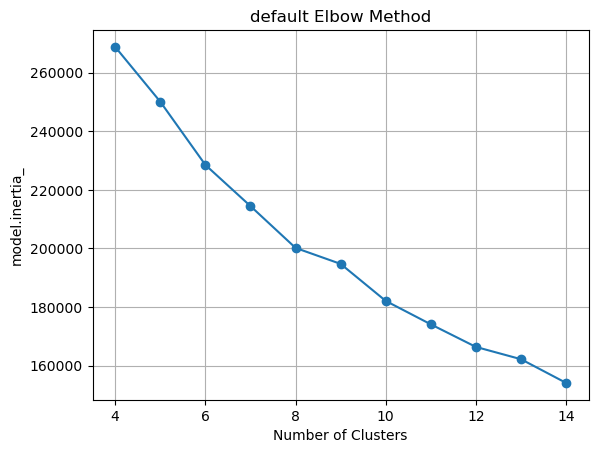

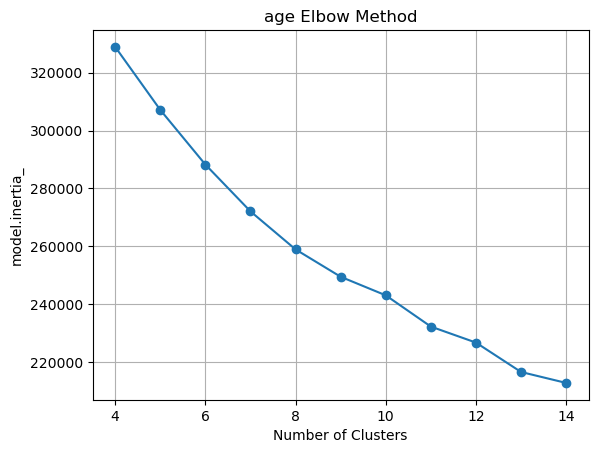

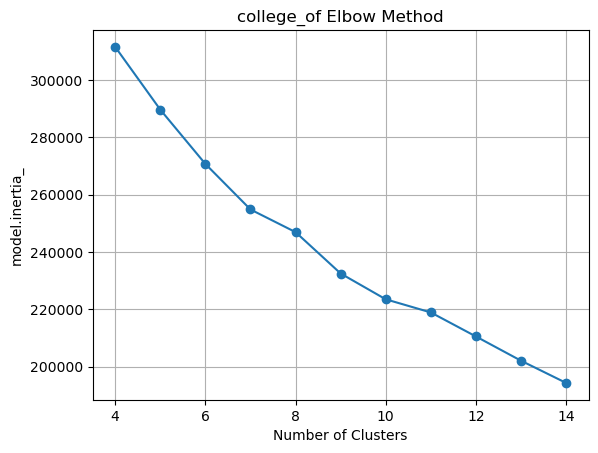

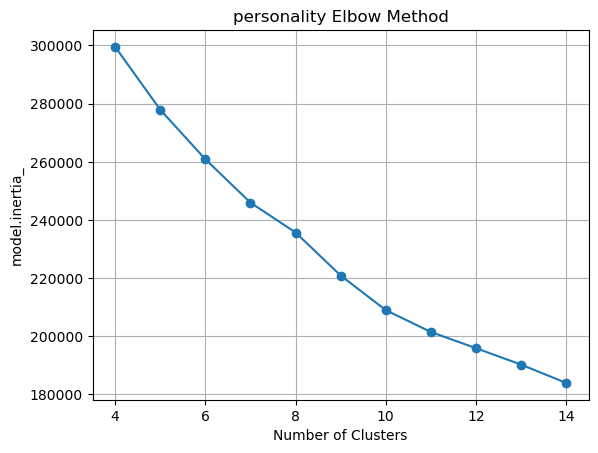

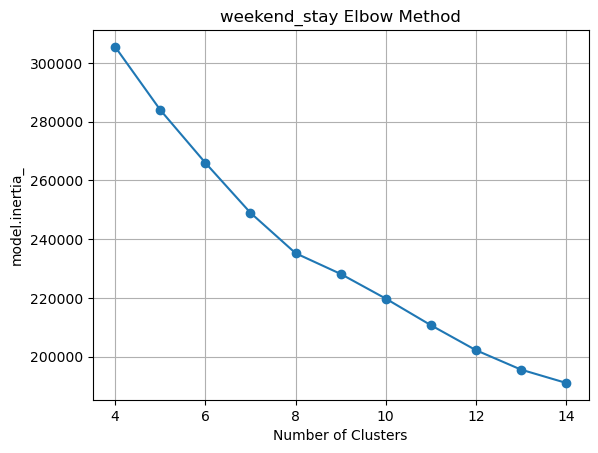

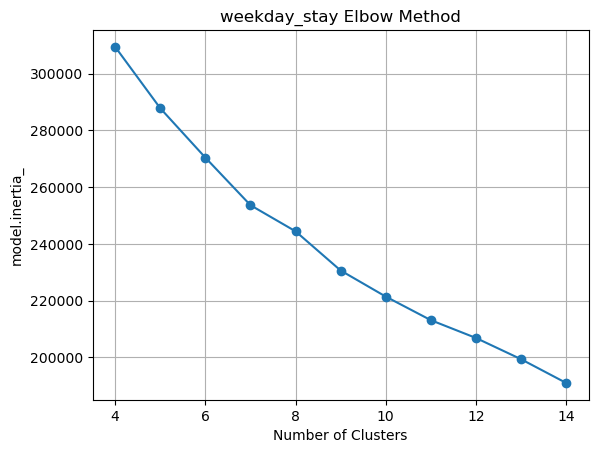

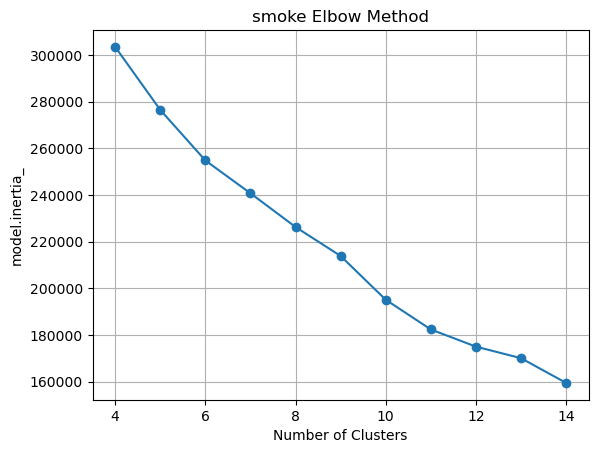

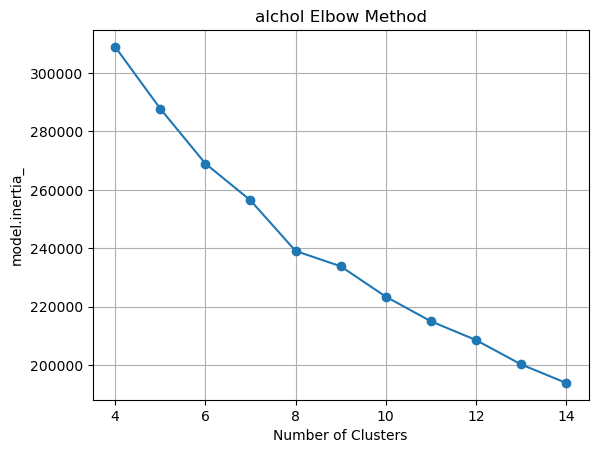

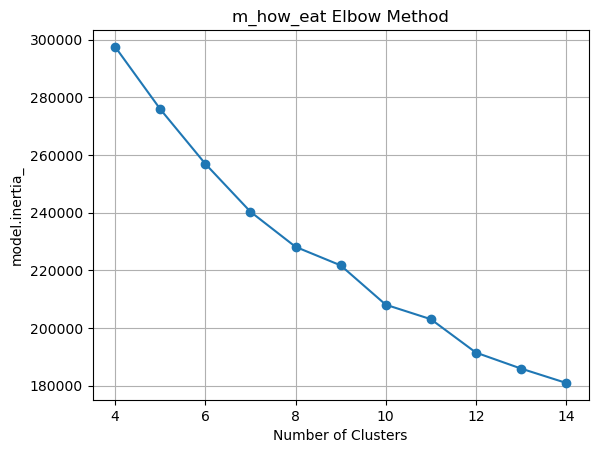

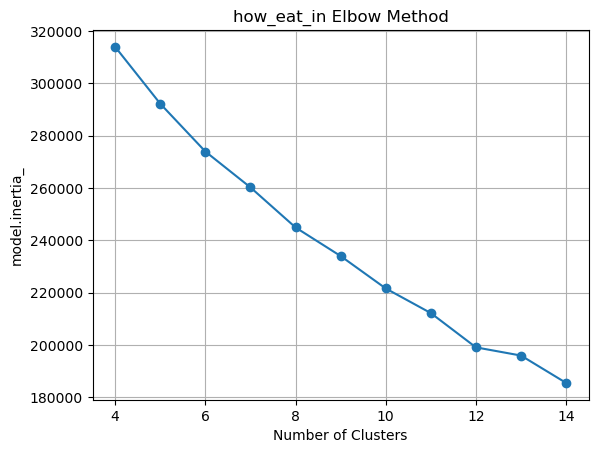

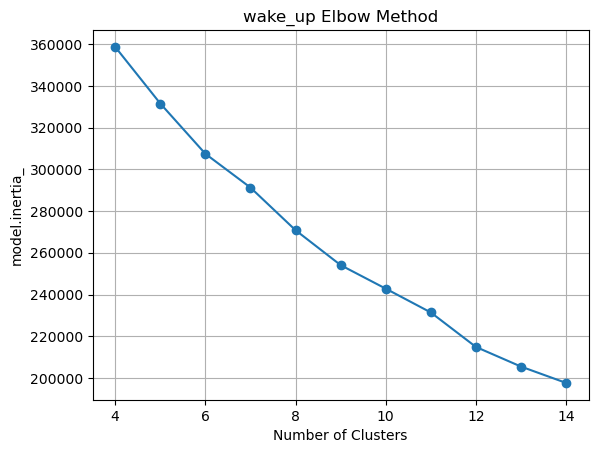

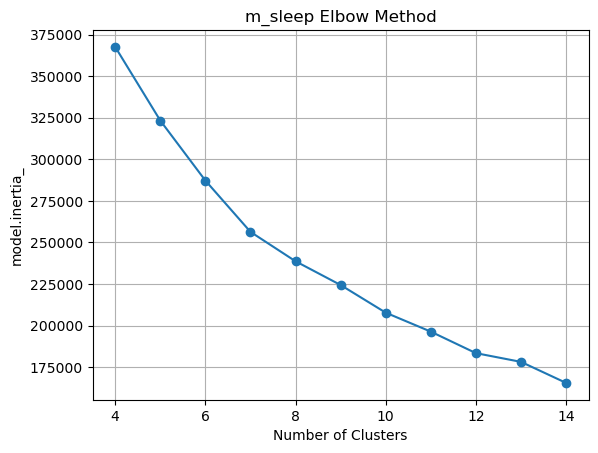

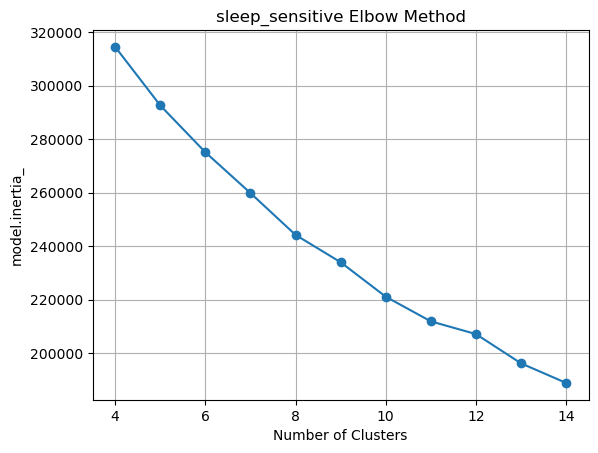

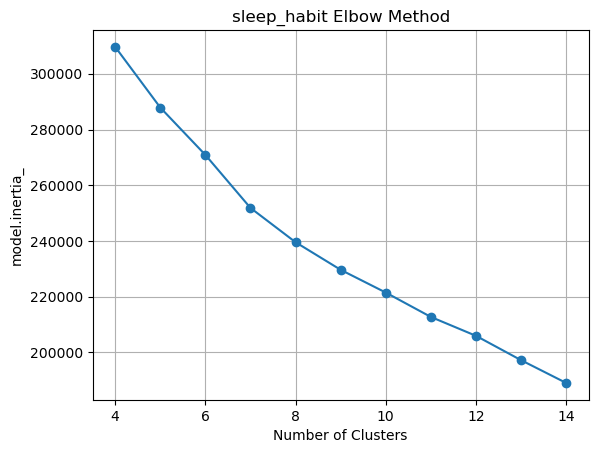

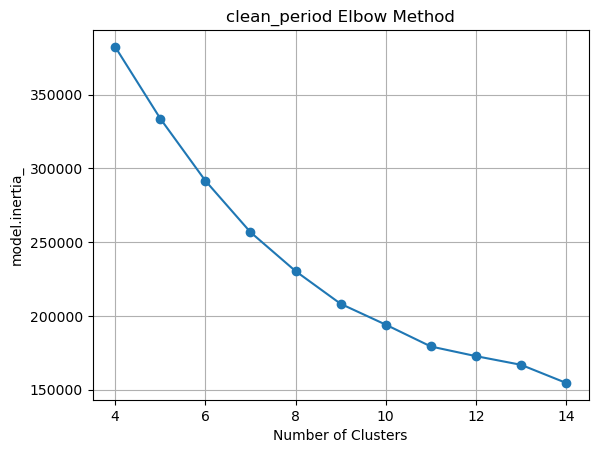

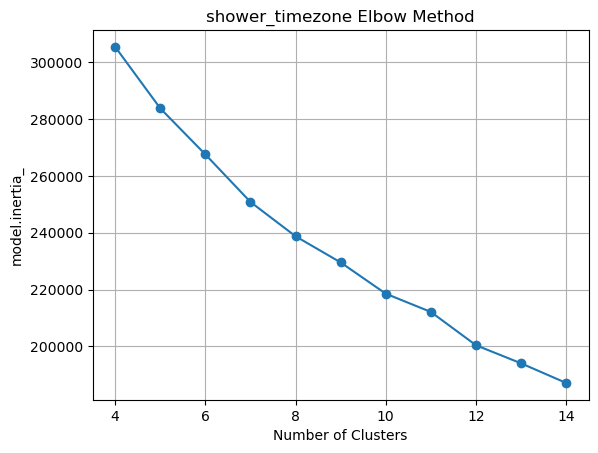

In [16]:
# 가중치 데이터 프레임별 그래프 그리기
for i, word in enumerate(words):
    k_values = range(4, 15)  # 클러스터 수 범위
    inertias = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=1)
        kmeans.fit_predict(dummy_dfs[word])
        inertias.append(kmeans.inertia_)

    plt.figure(i)
    plt.plot(k_values, inertias, marker='o')
    plt.title(f'{word} Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('model.inertia_')
    plt.grid(True)
    plt.show()


In [17]:
# !pip install --upgrade scikit-learn

In [18]:
clusters = {}

# ============여가에서 단어별로 모델링 변경 가능!!(클러스터 개수 결정 -> 반복문 x)================
for word in words:
    km = KMeans(n_clusters=9, n_init=10, random_state=1)
    cluster = km.fit_predict(dummy_dfs[word])
    clusters[word] = cluster

In [19]:
clusters['default']    # 클러스터링 개수도 변수마다 다르게 설정할까?? -> 일단 9개로 통일

array([1, 5, 5, 3, 8, 4, 5, 4, 4, 3, 8, 5, 4, 4, 4, 1, 0, 1, 1, 5, 5, 0,
       4, 1, 8, 1, 8, 1, 4, 4, 6, 0, 2, 7, 2, 4, 6, 5, 8, 1, 0, 5, 6, 4,
       8, 4, 0, 2, 4, 2, 4, 4, 0, 7, 6, 8, 5, 6, 7, 1, 1, 7, 5, 4, 1, 1,
       5, 7, 5, 2, 7, 5, 3, 6, 2, 7, 6, 0, 7, 6, 2, 5, 8, 3, 4, 1, 4, 1,
       4, 0, 2, 2, 1, 0, 2, 2, 1, 2, 7, 1, 0, 7, 0, 6, 6, 1, 4, 0, 4, 8,
       1, 0, 0, 2, 7, 1, 2, 2, 6, 0, 6, 2, 7, 7, 0, 6, 0, 2, 6, 1, 7, 6,
       0, 7, 1, 8, 8, 1, 7, 5, 1, 5, 8, 2, 1, 6, 5, 8, 6, 1, 2, 7, 0, 1,
       6, 0, 6, 2, 8, 6, 0, 7, 0, 6, 2, 4, 8, 5, 0, 8, 5, 0, 8, 1, 5, 0,
       0, 8, 0, 1, 1, 1, 7, 1, 4, 6, 4, 0, 1, 1, 1], dtype=int32)

In [20]:
# 라벨링 데이터에 각 변수별 클러스터 결과 열 추가
for word in words:
    label_df[f'{word}_cluster'] = clusters[word]

In [64]:
label_df.loc[label_df['default_cluster']==1].index

Int64Index([  0,  15,  17,  18,  23,  25,  27,  39,  59,  60,  64,  65,  85,
             87,  92,  96,  99, 105, 110, 115, 129, 134, 137, 140, 144, 149,
            153, 173, 179, 180, 181, 183, 188, 189, 190],
           dtype='int64')

In [21]:
# 보기 쉽게 라벨링 한 데이터에 클러스터 붙여 넣기
label_df.iloc[:, -16:].head()

,default_cluster,age_cluster,college_of_cluster,personality_cluster,weekend_stay_cluster,weekday_stay_cluster,smoke_cluster,alchol_cluster,m_how_eat_cluster,how_eat_in_cluster,wake_up_cluster,m_sleep_cluster,sleep_sensitive_cluster,sleep_habit_cluster,clean_period_cluster,shower_timezone_cluster
0,1,2,3,1,1,6,4,1,1,3,4,0,4,0,3,5
1,5,4,7,5,1,6,7,5,1,0,1,7,1,5,0,6
2,5,4,0,5,6,0,0,8,4,0,1,4,6,5,0,6
3,3,3,4,8,5,3,3,7,3,4,3,3,3,6,5,3
4,8,1,2,6,0,7,2,6,0,8,2,2,0,8,6,7


In [22]:
label_df.to_csv('cluster별_라벨링.csv')

In [23]:
# 학인용
label_df.loc[label_df['smoke_cluster']==0, 'smoke']   # 5~8 흡연자

2      1
6      1
11     1
20     1
41     1
56     1
62     1
66     1
68     1
71     1
139    1
167    1
170    1
174    1
Name: smoke, dtype: int64

## 그룹별 대표값 설정 
* 최대값을 대표값으로 설정
* 최대값이 너무 많을떈 다른값으로 대표값 변경

In [24]:
label_df = pd.read_csv('cluster별_라벨링.csv')

label_df = label_df.iloc[:, 1:]
label_df.head()

,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,...,smoke_cluster,alchol_cluster,m_how_eat_cluster,how_eat_in_cluster,wake_up_cluster,m_sleep_cluster,sleep_sensitive_cluster,sleep_habit_cluster,clean_period_cluster,shower_timezone_cluster
0,1,7,1,11,1,2,1,1,1,3,...,4,1,1,3,4,0,4,0,3,5
1,1,1,1,4,1,1,1,2,3,1,...,7,5,1,0,1,7,1,5,0,6
2,1,0,1,1,2,2,1,1,1,2,...,0,8,4,0,1,4,6,5,0,6
3,1,5,2,3,2,1,1,1,1,1,...,3,7,3,4,3,3,3,6,5,3
4,2,1,1,2,2,2,1,1,2,2,...,2,6,0,8,2,2,0,8,6,7


In [25]:
cols = list(label_df.columns[0:17])   # (내정보: 0 ~ 17번) 인덱스 이름
cols

['sex',
 'age',
 'dorm_select',
 'college_of',
 'personality',
 'weekend_stay',
 'weekday_stay',
 'smoke',
 'alchol',
 'm_how_eat',
 'how_eat_in',
 'wake_up',
 'm_sleep',
 'sleep_sensitive',
 'sleep_habit',
 'clean_period',
 'shower_timezone']

In [26]:
# 그룹별 내정보 저장하기(최대값으로 저장)
groups = {}        # 단어별로 클러스터링 그룹핑 결과

for word in words:
    group = label_df.groupby(f'{word}_cluster')
    groups[word] = group

#groups

In [27]:
# 학인용
#groups['default'].get_group(0)

In [28]:
# 최빈값 보정 함수
def pick_max(o_df, df, col, thres=0.5):
    feature_len = len(df[col].unique())
    max_feature = o_df[col].value_counts().idxmax()  #원본 df의 대푯값
    #print(f"{col}의 값 개수: {feature_len}, 전체 데이터 최빈값: {max_feature}")
    if feature_len <= 2:
        max_idx = df[col].value_counts().idxmax()
    else:
        #print(df[col].value_counts().iloc[0:3].to_frame('count').reset_index(), col)
        max_three_df = df[col].value_counts().iloc[0:3].to_frame('count').reset_index()
        if max_three_df.iloc[0, 0] == max_feature:
            if max_three_df.iloc[1, 1] > max_three_df.iloc[2, 1]:
                if (abs(max_three_df.iloc[1, 1]-max_three_df.iloc[0, 1])/max_three_df.iloc[0, 1])>thres:  #얼마만큼 차이 허용할지
                    max_idx=max_three_df.iloc[0, 0]
                else:
                    max_idx=max_three_df.iloc[1, 0]
            else:
                if (abs(max_three_df.iloc[2, 1]-max_three_df.iloc[0, 1])/max_three_df.iloc[0, 1])>thres:
                    
                    max_idx=max_three_df.iloc[0, 0]
                else:
                    max_idx=max_three_df.iloc[2, 0]
        else:
            max_idx=max_three_df.iloc[0, 0]
    #print(f"확정값 {max_idx}")
    return max_idx

In [29]:
# 드룹별 정보 확인
# cluster_group_df = []
# for name, group in groups['default']:
#     print("cluster: ", name)
#     print(len(group))
#     cluster_group_df.append(group)

In [30]:
for word, word_group in groups.items():
    print(f'Key: {word}, Value: {word_group}')

Key: default, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b9be710>
Key: age, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b9bf8e0>
Key: college_of, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b978340>
Key: personality, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b978130>
Key: weekend_stay, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b979990>
Key: weekday_stay, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b97b220>
Key: smoke, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b9b82e0>
Key: alchol, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b9b8e20>
Key: m_how_eat, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b9b8fa0>
Key: how_eat_in, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b9b9120>
Key: wake_up, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b9b9

In [31]:
group_datas = {}   # 단어별 그룹 대푯값 결과 저장

# 그룹별 대표값 계산
for word, word_group in groups.items():
    print(f'Key: {word}, Value: {word_group}')

    cluster_group = []   # word별로 클러스터별 대표값 저장
    for name, group in word_group:
        print(name)       # 클러스터 번호
        group_data = []   # 그룹별 변수의 최빈값 저장
        
        for col in cols:
            group_data.append(pick_max(label_df, group, col))
            
        cluster_group.append(group_data)

    display(cluster_group)   # 단어별 그룹핑 확인용
    groups_df = pd.DataFrame(cluster_group, columns=cols)   # 데이터 프레임 형태 변환
    
    group_datas[word] = groups_df    # 단어 사전에 그룹별 대표값 저장

Key: default, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b9be710>
0
1
2
3
4
5
6
7
8


[[2, 4, 1, 5, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 2],
 [1, 5, 1, 11, 2, 1, 1, 1, 1, 3, 2, 1, 2, 1, 3, 2, 1],
 [2, 1, 2, 4, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2],
 [1, 5, 2, 3, 2, 1, 1, 1, 2, 1, 2, 3, 3, 1, 2, 2, 2],
 [1, 5, 2, 7, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1],
 [1, 5, 1, 2, 2, 1, 2, 1, 2, 1, 2, 3, 3, 1, 2, 1, 1],
 [2, 4, 2, 7, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2],
 [2, 1, 2, 11, 1, 2, 2, 1, 1, 1, 2, 2, 3, 1, 1, 1, 2],
 [2, 5, 1, 5, 2, 1, 1, 1, 2, 2, 2, 2, 3, 1, 1, 1, 2]]

Key: age, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b9bf8e0>
0
1
2
3
4
5
6
7
8


[[2, 1, 2, 4, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2],
 [2, 5, 1, 5, 2, 1, 1, 1, 2, 2, 2, 2, 3, 1, 1, 1, 2],
 [1, 5, 1, 11, 2, 1, 1, 1, 1, 2, 2, 1, 3, 1, 1, 2, 1],
 [1, 5, 2, 7, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2],
 [1, 5, 1, 2, 2, 1, 2, 1, 2, 2, 2, 3, 3, 1, 2, 1, 1],
 [1, 1, 1, 2, 2, 1, 2, 1, 2, 3, 2, 2, 2, 1, 3, 2, 1],
 [2, 4, 1, 5, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 2],
 [2, 4, 2, 7, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2],
 [2, 1, 2, 11, 1, 2, 2, 1, 1, 1, 2, 2, 3, 1, 1, 1, 2]]

Key: college_of, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b978340>
0
1
2
3
4
5
6
7
8


[[1, 4, 1, 2, 2, 1, 1, 1, 2, 1, 2, 3, 3, 1, 2, 1, 1],
 [2, 1, 2, 11, 1, 2, 2, 1, 1, 1, 2, 2, 3, 1, 1, 1, 2],
 [2, 5, 1, 5, 2, 1, 1, 1, 2, 2, 2, 2, 3, 1, 1, 1, 2],
 [1, 1, 1, 11, 2, 1, 1, 1, 1, 3, 2, 1, 2, 1, 3, 2, 1],
 [1, 5, 2, 7, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2],
 [2, 4, 1, 5, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 2],
 [2, 1, 2, 4, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2],
 [1, 5, 1, 4, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 3, 1, 2],
 [2, 4, 2, 7, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2]]

Key: personality, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b978130>
0
1
2
3
4
5
6
7
8


[[2, 1, 2, 4, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2],
 [1, 5, 1, 11, 2, 1, 1, 1, 1, 3, 2, 1, 2, 1, 3, 2, 1],
 [2, 4, 1, 5, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 2],
 [1, 5, 2, 7, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1],
 [2, 4, 2, 7, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2],
 [1, 5, 1, 2, 2, 1, 2, 1, 2, 1, 2, 3, 3, 1, 2, 1, 1],
 [2, 5, 1, 5, 2, 1, 1, 1, 2, 2, 2, 2, 3, 1, 1, 1, 2],
 [2, 1, 2, 11, 1, 2, 2, 1, 1, 1, 2, 2, 3, 1, 1, 1, 2],
 [1, 5, 2, 3, 2, 2, 2, 1, 2, 1, 2, 1, 3, 1, 2, 2, 2]]

Key: weekend_stay, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b979990>
0
1
2
3
4
5
6
7
8


[[2, 4, 1, 5, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 3, 2, 2],
 [1, 1, 1, 11, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 1],
 [2, 1, 2, 4, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2],
 [1, 5, 2, 7, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2],
 [2, 1, 2, 11, 1, 2, 2, 1, 1, 1, 2, 2, 3, 1, 1, 1, 2],
 [1, 5, 2, 12, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1],
 [1, 5, 1, 2, 2, 1, 2, 1, 1, 2, 2, 3, 3, 1, 2, 1, 1],
 [2, 4, 2, 7, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2],
 [2, 2, 1, 5, 2, 1, 1, 1, 1, 1, 2, 3, 3, 1, 3, 1, 2]]

Key: weekday_stay, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b97b220>
0
1
2
3
4
5
6
7
8


[[1, 5, 1, 2, 2, 2, 2, 1, 1, 2, 2, 3, 2, 1, 2, 1, 1],
 [2, 4, 1, 5, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 2],
 [2, 1, 2, 4, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2],
 [1, 5, 2, 7, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2],
 [1, 1, 1, 2, 2, 1, 2, 1, 1, 3, 2, 1, 2, 1, 2, 2, 1],
 [2, 4, 2, 7, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2],
 [1, 5, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 2, 1],
 [2, 5, 1, 5, 2, 1, 1, 1, 2, 2, 2, 2, 3, 1, 1, 1, 2],
 [2, 1, 2, 11, 1, 2, 2, 1, 1, 1, 2, 2, 3, 1, 1, 1, 2]]

Key: smoke, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b9b82e0>
0
1
2
3
4
5
6
7
8


[[1, 4, 1, 2, 2, 2, 2, 1, 1, 2, 2, 3, 3, 1, 2, 1, 1],
 [2, 1, 2, 4, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2],
 [2, 3, 1, 5, 2, 1, 1, 1, 1, 1, 2, 1, 3, 1, 3, 2, 2],
 [1, 5, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1],
 [1, 1, 1, 11, 2, 1, 1, 1, 1, 3, 2, 1, 2, 1, 3, 2, 1],
 [2, 1, 2, 11, 1, 2, 1, 1, 1, 1, 2, 3, 2, 1, 2, 3, 2],
 [2, 4, 2, 7, 2, 2, 1, 1, 2, 1, 2, 1, 3, 1, 1, 1, 2],
 [1, 5, 1, 4, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 3, 1, 2],
 [1, 1, 2, 11, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2]]

Key: alchol, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b9b8e20>
0
1
2
3
4
5
6
7
8


[[2, 4, 1, 5, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 2],
 [1, 1, 1, 11, 2, 1, 1, 1, 1, 3, 2, 1, 2, 1, 3, 2, 1],
 [2, 1, 2, 11, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2],
 [1, 5, 2, 7, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2],
 [2, 4, 2, 7, 1, 2, 1, 1, 2, 1, 2, 2, 3, 1, 1, 1, 2],
 [1, 5, 1, 4, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 3, 1, 2],
 [2, 5, 1, 5, 2, 1, 1, 1, 2, 2, 2, 2, 3, 1, 1, 1, 2],
 [1, 5, 2, 12, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1],
 [1, 4, 1, 2, 2, 1, 1, 1, 2, 1, 2, 3, 3, 1, 2, 1, 1]]

Key: m_how_eat, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b9b8fa0>
0
1
2
3
4
5
6
7
8


[[2, 2, 1, 5, 2, 1, 1, 1, 2, 2, 2, 2, 3, 1, 1, 1, 2],
 [1, 1, 1, 11, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 1],
 [2, 1, 2, 4, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2],
 [1, 5, 2, 7, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2],
 [1, 5, 1, 2, 2, 1, 2, 1, 1, 2, 2, 3, 3, 1, 2, 1, 1],
 [2, 4, 1, 6, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 3, 2, 2],
 [2, 1, 2, 11, 1, 2, 2, 1, 1, 1, 2, 2, 3, 1, 1, 1, 2],
 [2, 4, 2, 7, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2],
 [2, 4, 1, 5, 2, 1, 1, 1, 2, 1, 2, 3, 3, 1, 3, 2, 1]]

Key: how_eat_in, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b9b9120>
0
1
2
3
4
5
6
7
8


[[1, 5, 1, 2, 2, 1, 2, 1, 2, 1, 2, 3, 3, 1, 2, 1, 1],
 [2, 1, 2, 4, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2],
 [2, 5, 1, 4, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 3, 1, 2],
 [1, 5, 1, 11, 2, 1, 1, 1, 1, 3, 2, 1, 2, 1, 3, 2, 1],
 [1, 5, 2, 7, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2],
 [2, 4, 1, 5, 2, 1, 1, 1, 1, 1, 2, 1, 3, 1, 3, 2, 2],
 [2, 4, 2, 7, 2, 2, 1, 1, 2, 1, 2, 1, 3, 1, 1, 1, 2],
 [2, 1, 2, 11, 1, 2, 2, 1, 1, 2, 2, 2, 3, 1, 1, 2, 2],
 [2, 1, 1, 5, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2]]

Key: wake_up, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b9b92a0>
0
1
2
3
4
5
6
7
8


[[2, 3, 2, 11, 1, 2, 2, 1, 1, 1, 2, 3, 3, 1, 1, 1, 2],
 [1, 5, 1, 11, 2, 1, 2, 1, 2, 2, 2, 1, 3, 1, 2, 2, 1],
 [2, 4, 1, 5, 2, 2, 1, 1, 1, 1, 2, 2, 3, 1, 3, 2, 2],
 [1, 5, 2, 7, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2],
 [1, 4, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 3, 2, 1],
 [2, 1, 2, 11, 1, 2, 2, 1, 2, 1, 2, 2, 3, 1, 1, 1, 1],
 [2, 5, 2, 7, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2],
 [2, 3, 1, 5, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 3, 2, 2],
 [2, 0, 1, 4, 1, 1, 1, 1, 2, 1, 2, 3, 3, 1, 1, 3, 2]]

Key: m_sleep, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b9b9420>
0
1
2
3
4
5
6
7
8


[[1, 5, 1, 11, 2, 1, 1, 1, 1, 2, 2, 3, 3, 1, 1, 1, 1],
 [2, 1, 2, 11, 1, 2, 2, 1, 1, 1, 2, 2, 3, 1, 1, 1, 2],
 [2, 4, 1, 3, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 3, 2, 2],
 [1, 5, 2, 7, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2],
 [1, 1, 1, 2, 2, 1, 2, 1, 2, 3, 2, 2, 2, 1, 2, 2, 1],
 [2, 2, 1, 5, 2, 1, 1, 1, 1, 1, 2, 3, 3, 1, 3, 1, 2],
 [2, 1, 2, 4, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2],
 [1, 5, 1, 4, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 3, 2, 1],
 [2, 4, 2, 7, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2]]

Key: sleep_sensitive, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b9b95a0>
0
1
2
3
4
5
6
7
8


[[2, 5, 1, 5, 2, 1, 1, 1, 2, 2, 2, 2, 3, 1, 1, 1, 2],
 [1, 5, 1, 11, 2, 1, 1, 1, 1, 1, 2, 1, 3, 2, 2, 1, 1],
 [2, 1, 2, 4, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2],
 [1, 5, 2, 7, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2],
 [1, 5, 1, 2, 2, 1, 1, 1, 1, 1, 2, 3, 3, 1, 1, 2, 2],
 [2, 1, 2, 11, 1, 2, 1, 1, 1, 1, 2, 2, 3, 1, 1, 1, 2],
 [1, 1, 1, 2, 2, 1, 2, 1, 2, 3, 2, 1, 2, 1, 3, 2, 1],
 [2, 4, 2, 7, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2],
 [2, 4, 1, 5, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 2]]

Key: sleep_habit, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b9b9720>
0
1
2
3
4
5
6
7
8


[[1, 5, 1, 11, 2, 1, 1, 1, 1, 3, 2, 1, 2, 1, 3, 2, 1],
 [2, 4, 2, 7, 2, 2, 1, 1, 2, 1, 2, 1, 3, 1, 1, 1, 2],
 [2, 4, 1, 5, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 2],
 [1, 5, 2, 7, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2],
 [2, 1, 2, 4, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2],
 [1, 5, 1, 2, 2, 1, 2, 1, 2, 1, 2, 3, 3, 1, 2, 1, 1],
 [1, 5, 2, 12, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1],
 [2, 1, 2, 11, 1, 2, 1, 1, 1, 1, 2, 3, 2, 1, 2, 3, 2],
 [2, 5, 1, 5, 2, 1, 1, 1, 2, 2, 2, 2, 3, 1, 1, 1, 2]]

Key: clean_period, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b9780d0>
0
1
2
3
4
5
6
7
8


[[1, 5, 1, 2, 2, 1, 2, 1, 2, 1, 2, 3, 3, 1, 2, 1, 1],
 [2, 4, 1, 5, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 2],
 [2, 4, 2, 7, 2, 2, 1, 1, 2, 1, 2, 1, 3, 1, 1, 1, 2],
 [1, 5, 1, 11, 2, 1, 1, 1, 1, 3, 2, 1, 2, 1, 3, 2, 1],
 [2, 1, 2, 4, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2],
 [1, 5, 2, 12, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1],
 [2, 5, 1, 5, 2, 1, 1, 1, 2, 2, 2, 2, 3, 1, 1, 1, 2],
 [1, 5, 2, 7, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2],
 [2, 1, 2, 11, 1, 2, 1, 1, 1, 1, 2, 3, 2, 1, 2, 3, 2]]

Key: shower_timezone, Value: <pandas.core.groupby.generic.DataFrameGroupBy object at 0x14b978610>
0
1
2
3
4
5
6
7
8


[[2, 4, 1, 5, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 2],
 [1, 5, 1, 11, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 3, 2, 1],
 [2, 1, 2, 4, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2],
 [1, 5, 2, 7, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2],
 [2, 1, 2, 11, 1, 2, 2, 1, 1, 1, 2, 3, 3, 1, 1, 3, 2],
 [1, 1, 1, 5, 2, 2, 1, 1, 1, 3, 2, 1, 3, 1, 1, 2, 2],
 [1, 5, 1, 2, 2, 1, 2, 1, 2, 2, 2, 3, 2, 1, 2, 1, 1],
 [2, 5, 1, 5, 2, 1, 1, 1, 2, 2, 2, 2, 3, 1, 1, 1, 2],
 [2, 4, 2, 7, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2]]

In [32]:
# default일때 group별 대표값 확인
#groups['default'].get_group(1)

In [33]:
for word, dfs in group_datas.items():
    print(word)
    display(dfs)
    dfs.to_csv(f'변수별_클러스터대푯값/{word}_cluster_representative.csv')

default


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,2,4,1,5,2,2,1,1,1,1,2,1,2,1,3,2,2
1,1,5,1,11,2,1,1,1,1,3,2,1,2,1,3,2,1
2,2,1,2,4,1,1,1,1,2,1,2,1,2,1,1,2,2
3,1,5,2,3,2,1,1,1,2,1,2,3,3,1,2,2,2
4,1,5,2,7,2,2,2,1,1,2,2,1,2,1,1,2,1
5,1,5,1,2,2,1,2,1,2,1,2,3,3,1,2,1,1
6,2,4,2,7,2,2,1,1,2,1,2,1,2,1,1,1,2
7,2,1,2,11,1,2,2,1,1,1,2,2,3,1,1,1,2
8,2,5,1,5,2,1,1,1,2,2,2,2,3,1,1,1,2


age


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,2,1,2,4,1,1,1,1,2,1,2,1,2,1,1,2,2
1,2,5,1,5,2,1,1,1,2,2,2,2,3,1,1,1,2
2,1,5,1,11,2,1,1,1,1,2,2,1,3,1,1,2,1
3,1,5,2,7,2,2,2,1,1,2,2,2,2,1,1,2,2
4,1,5,1,2,2,1,2,1,2,2,2,3,3,1,2,1,1
5,1,1,1,2,2,1,2,1,2,3,2,2,2,1,3,2,1
6,2,4,1,5,2,2,1,1,1,1,2,1,2,1,3,2,2
7,2,4,2,7,2,2,1,1,2,1,2,1,2,1,1,1,2
8,2,1,2,11,1,2,2,1,1,1,2,2,3,1,1,1,2


college_of


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,1,4,1,2,2,1,1,1,2,1,2,3,3,1,2,1,1
1,2,1,2,11,1,2,2,1,1,1,2,2,3,1,1,1,2
2,2,5,1,5,2,1,1,1,2,2,2,2,3,1,1,1,2
3,1,1,1,11,2,1,1,1,1,3,2,1,2,1,3,2,1
4,1,5,2,7,2,2,2,1,1,2,2,2,2,1,1,2,2
5,2,4,1,5,2,2,1,1,1,1,2,1,2,1,3,2,2
6,2,1,2,4,1,1,1,1,2,1,2,1,2,1,1,2,2
7,1,5,1,4,1,1,2,2,2,2,2,1,1,1,3,1,2
8,2,4,2,7,2,2,1,1,2,1,2,1,2,1,1,1,2


personality


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,2,1,2,4,1,1,1,1,2,1,2,1,2,1,1,2,2
1,1,5,1,11,2,1,1,1,1,3,2,1,2,1,3,2,1
2,2,4,1,5,2,2,1,1,1,1,2,1,2,1,3,2,2
3,1,5,2,7,2,2,2,1,1,2,2,2,2,1,1,2,1
4,2,4,2,7,2,2,1,1,2,1,2,1,2,1,1,1,2
5,1,5,1,2,2,1,2,1,2,1,2,3,3,1,2,1,1
6,2,5,1,5,2,1,1,1,2,2,2,2,3,1,1,1,2
7,2,1,2,11,1,2,2,1,1,1,2,2,3,1,1,1,2
8,1,5,2,3,2,2,2,1,2,1,2,1,3,1,2,2,2


weekend_stay


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,2,4,1,5,2,1,2,1,1,1,2,1,2,1,3,2,2
1,1,1,1,11,2,1,1,1,1,1,2,1,2,1,3,2,1
2,2,1,2,4,1,1,1,1,2,1,2,1,2,1,1,2,2
3,1,5,2,7,2,2,2,1,1,1,2,1,2,1,1,1,2
4,2,1,2,11,1,2,2,1,1,1,2,2,3,1,1,1,2
5,1,5,2,12,2,1,2,1,1,2,2,2,2,1,1,2,1
6,1,5,1,2,2,1,2,1,1,2,2,3,3,1,2,1,1
7,2,4,2,7,2,2,2,1,2,1,2,1,2,1,1,1,2
8,2,2,1,5,2,1,1,1,1,1,2,3,3,1,3,1,2


weekday_stay


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,1,5,1,2,2,2,2,1,1,2,2,3,2,1,2,1,1
1,2,4,1,5,2,2,1,1,1,1,2,1,2,1,3,2,2
2,2,1,2,4,1,1,1,1,2,1,2,1,2,1,1,2,2
3,1,5,2,7,2,2,2,1,1,2,2,2,2,1,1,2,2
4,1,1,1,2,2,1,2,1,1,3,2,1,2,1,2,2,1
5,2,4,2,7,2,2,2,1,2,1,2,1,2,1,1,1,2
6,1,5,1,2,2,1,1,1,1,1,2,1,3,1,1,2,1
7,2,5,1,5,2,1,1,1,2,2,2,2,3,1,1,1,2
8,2,1,2,11,1,2,2,1,1,1,2,2,3,1,1,1,2


smoke


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,1,4,1,2,2,2,2,1,1,2,2,3,3,1,2,1,1
1,2,1,2,4,1,2,2,1,2,1,2,1,2,1,1,2,2
2,2,3,1,5,2,1,1,1,1,1,2,1,3,1,3,2,2
3,1,5,2,2,2,1,2,1,1,2,2,2,2,1,1,2,1
4,1,1,1,11,2,1,1,1,1,3,2,1,2,1,3,2,1
5,2,1,2,11,1,2,1,1,1,1,2,3,2,1,2,3,2
6,2,4,2,7,2,2,1,1,2,1,2,1,3,1,1,1,2
7,1,5,1,4,1,1,2,2,2,2,2,1,1,1,3,1,2
8,1,1,2,11,2,2,2,2,2,2,2,1,1,1,1,2,2


alchol


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,2,4,1,5,2,2,1,1,1,1,2,1,2,1,3,2,2
1,1,1,1,11,2,1,1,1,1,3,2,1,2,1,3,2,1
2,2,1,2,11,1,2,1,1,2,1,2,1,2,1,1,2,2
3,1,5,2,7,2,2,2,1,1,1,2,1,2,1,1,1,2
4,2,4,2,7,1,2,1,1,2,1,2,2,3,1,1,1,2
5,1,5,1,4,1,1,2,2,2,2,2,1,1,1,3,1,2
6,2,5,1,5,2,1,1,1,2,2,2,2,3,1,1,1,2
7,1,5,2,12,2,1,2,1,1,2,2,2,2,1,1,2,1
8,1,4,1,2,2,1,1,1,2,1,2,3,3,1,2,1,1


m_how_eat


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,2,2,1,5,2,1,1,1,2,2,2,2,3,1,1,1,2
1,1,1,1,11,2,1,1,1,1,1,2,1,2,1,3,2,1
2,2,1,2,4,1,2,1,1,2,1,2,1,2,1,1,2,2
3,1,5,2,7,2,2,2,1,1,2,2,2,2,1,1,2,2
4,1,5,1,2,2,1,2,1,1,2,2,3,3,1,2,1,1
5,2,4,1,6,2,2,2,1,1,1,2,1,2,1,3,2,2
6,2,1,2,11,1,2,2,1,1,1,2,2,3,1,1,1,2
7,2,4,2,7,2,2,1,1,2,1,2,1,2,1,1,1,2
8,2,4,1,5,2,1,1,1,2,1,2,3,3,1,3,2,1


how_eat_in


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,1,5,1,2,2,1,2,1,2,1,2,3,3,1,2,1,1
1,2,1,2,4,1,1,1,1,2,1,2,1,2,1,1,2,2
2,2,5,1,4,2,2,2,1,1,1,1,1,2,1,3,1,2
3,1,5,1,11,2,1,1,1,1,3,2,1,2,1,3,2,1
4,1,5,2,7,2,2,2,1,1,2,2,2,2,1,1,2,2
5,2,4,1,5,2,1,1,1,1,1,2,1,3,1,3,2,2
6,2,4,2,7,2,2,1,1,2,1,2,1,3,1,1,1,2
7,2,1,2,11,1,2,2,1,1,2,2,2,3,1,1,2,2
8,2,1,1,5,2,1,1,1,2,2,2,2,2,1,1,1,2


wake_up


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,2,3,2,11,1,2,2,1,1,1,2,3,3,1,1,1,2
1,1,5,1,11,2,1,2,1,2,2,2,1,3,1,2,2,1
2,2,4,1,5,2,2,1,1,1,1,2,2,3,1,3,2,2
3,1,5,2,7,2,2,2,1,1,2,2,2,2,1,1,2,2
4,1,4,1,2,2,1,1,1,1,1,2,2,2,1,3,2,1
5,2,1,2,11,1,2,2,1,2,1,2,2,3,1,1,1,1
6,2,5,2,7,2,1,1,1,2,1,2,1,2,1,1,1,2
7,2,3,1,5,2,1,2,1,1,1,2,1,2,1,3,2,2
8,2,0,1,4,1,1,1,1,2,1,2,3,3,1,1,3,2


m_sleep


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,1,5,1,11,2,1,1,1,1,2,2,3,3,1,1,1,1
1,2,1,2,11,1,2,2,1,1,1,2,2,3,1,1,1,2
2,2,4,1,3,2,1,2,1,1,1,2,1,2,1,3,2,2
3,1,5,2,7,2,2,2,1,1,2,2,2,2,1,1,2,2
4,1,1,1,2,2,1,2,1,2,3,2,2,2,1,2,2,1
5,2,2,1,5,2,1,1,1,1,1,2,3,3,1,3,1,2
6,2,1,2,4,1,1,1,1,2,1,2,1,2,1,1,2,2
7,1,5,1,4,1,1,2,1,1,2,2,1,1,2,3,2,1
8,2,4,2,7,2,2,2,1,2,1,2,1,2,1,1,1,2


sleep_sensitive


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,2,5,1,5,2,1,1,1,2,2,2,2,3,1,1,1,2
1,1,5,1,11,2,1,1,1,1,1,2,1,3,2,2,1,1
2,2,1,2,4,1,2,2,1,2,1,2,1,2,1,1,2,2
3,1,5,2,7,2,2,2,1,1,2,2,2,2,1,1,2,2
4,1,5,1,2,2,1,1,1,1,1,2,3,3,1,1,2,2
5,2,1,2,11,1,2,1,1,1,1,2,2,3,1,1,1,2
6,1,1,1,2,2,1,2,1,2,3,2,1,2,1,3,2,1
7,2,4,2,7,2,2,1,1,2,1,2,1,2,1,1,1,2
8,2,4,1,5,2,2,1,1,1,1,2,1,2,1,3,2,2


sleep_habit


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,1,5,1,11,2,1,1,1,1,3,2,1,2,1,3,2,1
1,2,4,2,7,2,2,1,1,2,1,2,1,3,1,1,1,2
2,2,4,1,5,2,2,1,1,1,1,2,1,2,1,3,2,2
3,1,5,2,7,2,2,2,1,1,1,2,1,2,1,1,1,2
4,2,1,2,4,1,2,2,1,2,1,2,1,2,1,1,2,2
5,1,5,1,2,2,1,2,1,2,1,2,3,3,1,2,1,1
6,1,5,2,12,2,2,2,1,1,2,2,2,2,1,1,2,1
7,2,1,2,11,1,2,1,1,1,1,2,3,2,1,2,3,2
8,2,5,1,5,2,1,1,1,2,2,2,2,3,1,1,1,2


clean_period


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,1,5,1,2,2,1,2,1,2,1,2,3,3,1,2,1,1
1,2,4,1,5,2,2,1,1,1,1,2,1,2,1,3,2,2
2,2,4,2,7,2,2,1,1,2,1,2,1,3,1,1,1,2
3,1,5,1,11,2,1,1,1,1,3,2,1,2,1,3,2,1
4,2,1,2,4,1,2,2,1,2,1,2,1,2,1,1,2,2
5,1,5,2,12,2,2,2,1,1,2,2,2,2,1,1,2,1
6,2,5,1,5,2,1,1,1,2,2,2,2,3,1,1,1,2
7,1,5,2,7,2,2,2,1,1,1,2,1,2,1,1,1,2
8,2,1,2,11,1,2,1,1,1,1,2,3,2,1,2,3,2


shower_timezone


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,2,4,1,5,2,2,1,1,1,1,2,1,2,1,3,2,2
1,1,5,1,11,2,1,2,1,1,1,2,2,2,1,3,2,1
2,2,1,2,4,1,1,1,1,2,1,2,1,2,1,1,2,2
3,1,5,2,7,2,2,2,1,1,2,2,2,2,1,1,2,2
4,2,1,2,11,1,2,2,1,1,1,2,3,3,1,1,3,2
5,1,1,1,5,2,2,1,1,1,3,2,1,3,1,1,2,2
6,1,5,1,2,2,1,2,1,2,2,2,3,2,1,2,1,1
7,2,5,1,5,2,1,1,1,2,2,2,2,3,1,1,1,2
8,2,4,2,7,2,2,1,1,2,1,2,1,2,1,1,1,2


# 5. 새로운 사용자 데이터를 이용해 클러스터 선택

In [34]:
# 새로운 사용자 정보 입력
new_df = {'email': 'lhj5561@naver.com', 'sex': 1, 'age': 7, 'dorm_select': 1, 'college_of': 8, 'personality': 1, 'weekend_stay': 2,
 'weekday_stay': 1, 'smoke': 1, 'alchol': 1, 'm_how_eat': 3, 'how_eat_in': 2, 'wake_up': 1, 'm_sleep': 3, 'sleep_sensitive': 2,
 'sleep_habit': 3, 'clean_period': 2, 'shower_timezone': 1, 'w_age_range': 3, 'w_diff_college_of': 1, 'w_personality': 0,
 'w_weekend_stay': 2, 'w_weekday_stay': 2, 'w_smoke': 1, 'w_alchol': 1, 'w_how_eat': 3, 'w_how_eat_in': 3, 'w_wake_up': 0,
 'w_sleep': 3, 'w_sleep_sensitive': 1, 'w_sleep_habit': 1, 'w_clean_period': 3, 'w_shower_timezone': 1}

add_info = ['alchol', 'smoke', 'clean_period']    # 사전을 통해 나온 결과 단어들 저장 (가정하에)

email = new_df['email']  # 이메일 값 따로 저장
del new_df['email']      # 이메일 제거
new_df

{'sex': 1,
 'age': 7,
 'dorm_select': 1,
 'college_of': 8,
 'personality': 1,
 'weekend_stay': 2,
 'weekday_stay': 1,
 'smoke': 1,
 'alchol': 1,
 'm_how_eat': 3,
 'how_eat_in': 2,
 'wake_up': 1,
 'm_sleep': 3,
 'sleep_sensitive': 2,
 'sleep_habit': 3,
 'clean_period': 2,
 'shower_timezone': 1,
 'w_age_range': 3,
 'w_diff_college_of': 1,
 'w_personality': 0,
 'w_weekend_stay': 2,
 'w_weekday_stay': 2,
 'w_smoke': 1,
 'w_alchol': 1,
 'w_how_eat': 3,
 'w_how_eat_in': 3,
 'w_wake_up': 0,
 'w_sleep': 3,
 'w_sleep_sensitive': 1,
 'w_sleep_habit': 1,
 'w_clean_period': 3,
 'w_shower_timezone': 1}

In [35]:
want_info = col_list[18:]   # 원하는 상대방 정보 열 이름들
my_info = col_list[1:18]     # 내정보 열 이름들 -> [sex, dorm_select]

print(want_info)
print(my_info)

['w_age_range', 'w_diff_college_of', 'w_personality', 'w_weekend_stay', 'w_weekday_stay', 'w_smoke', 'w_alchol', 'w_how_eat', 'w_how_eat_in', 'w_wake_up', 'w_sleep', 'w_sleep_sensitive', 'w_sleep_habit', 'w_clean_period', 'w_shower_timezone']
['sex', 'age', 'dorm_select', 'college_of', 'personality', 'weekend_stay', 'weekday_stay', 'smoke', 'alchol', 'm_how_eat', 'how_eat_in', 'wake_up', 'm_sleep', 'sleep_sensitive', 'sleep_habit', 'clean_period', 'shower_timezone']


In [36]:
# 내정보 변수별 가능한 값들
unique_data = []
for name in my_info:
    unique_data.append(len(label_df[name].value_counts()))

unique_data

[2, 9, 2, 13, 2, 2, 2, 2, 3, 3, 2, 4, 3, 2, 3, 3, 2]

In [37]:
# 그룹의 대표 나이 String 값 추출 함수
def age_generate_string(df):
    count_dict = df['age'].value_counts().to_dict()
    sorted_counts = sorted(count_dict.items(), key=lambda x: (x[1], x[0]), reverse=True)  
    temp_age_encode=[0]*4
    
    for key, value in sorted_counts:   # 인코딩된 나이를 빈도 순서로 나타낸 다음 -> 순서를 정함
        if key<=2:
            temp_age_encode[0]+=value
        elif key>=3 and key<=4:
            temp_age_encode[1]+=value
        elif key>=5 and key<=6:
            temp_age_encode[2]+=value
        elif key>=7:
            temp_age_encode[3]+=value
    
    temp_age_encode=np.argsort(temp_age_encode)[::-1]
    result = '-'.join([str(sub+1) for sub in temp_age_encode])
    return result

# 그룹의 대표 인덱스 위치 찾아내기
def age_get_index_based_on_string(option, generated_string, alp=1):
    string_part = generated_string.split('-')
    idx=0

    if(option!=5):
        idx=string_part.index(str(option))   # 인덱스의 위치가 거리이다.

    return (abs(idx*alp))/3

In [38]:
# 기존 group에서 단과대의 수가 많은 순으로 정렬한 결과를 문자열로 바꿔주는 함수 "12-1-3..."
def college_generate_string(df):
    count_dict = df['college_of'].value_counts().to_dict()
    sorted_counts = sorted(count_dict.items(), key=lambda x: (x[1], x[0]), reverse=True)  

    result = '-'.join([str(key) for key, _ in sorted_counts])
    return result

# 사용자로부터 입력받은 단과대와 같은 단과대 희망 여부를 문자열로 바꿔주는 함수 "3-2"
def college_convert_to_string(df):
    strings = []
    college_of = str(df['college_of'])
    w_diff_college_of = str(df['w_diff_college_of'])
    strings.append(f"{college_of}-{w_diff_college_of}")
    result = '-'.join(strings)
    return result

def college_get_index_based_on_string(converted_string, generated_string,alp=1):
    string_part = generated_string.split('-')
    conv_string_part=converted_string.split('-')
    idx=0
    div_by=13
    if(conv_string_part[1]=='3'):
        return (0*alp)/div_by

    try:
        idx=string_part.index(conv_string_part[0])
    except:
        if(conv_string_part[1]=='1'):
            return (13*alp)/div_by
        else:
            return (0*alp)/div_by

    if(conv_string_part[1]=='1'):
        return (idx*alp)/div_by
    else:
        return ((13-idx)*alp)/div_by

In [39]:
my_info

['sex',
 'age',
 'dorm_select',
 'college_of',
 'personality',
 'weekend_stay',
 'weekday_stay',
 'smoke',
 'alchol',
 'm_how_eat',
 'how_eat_in',
 'wake_up',
 'm_sleep',
 'sleep_sensitive',
 'sleep_habit',
 'clean_period',
 'shower_timezone']

In [40]:
def cal_dis(word):
    # 9개의 클러스터와 나의 거리 저장
    distance = [100]*9

    for i, row in group_datas[word].iterrows():
        row = list(row)
        print(i, row)
        # 성별이나 거주 홀이 다른 경우 패스
        if (row[0] != new_df['sex']) or (row[2] != new_df['dorm_select']):
            print('나이, 거주홀 통과')
            continue

        # 성별, 거주홀이 같은 경우
        distance[i] = 0
        k = 2    # 나이, 단과대는 따로 계산
        d = 0    # 거리 누적값
        for j in range(len(row)):
            if j < 4:
                print(f"{my_info[j]} 생략")    # 추후에 결정
                # <====준모, 태윤 코드 대입!!====>
                # (j == 1(나이)) , (j == 2(단과대)) 일때 코드만 처리하면 됨!!
                if(j==1):
                    age_result_string = age_generate_string(groups[word].get_group(i))  
                    age_distance=age_get_index_based_on_string(new_df['w_age_range'], age_result_string)
                    distance[i] += age_distance 
                elif(j==2):
                    college_result_string = college_generate_string(groups[word].get_group(i))
                    college_convert_string=college_convert_to_string(new_df)
                    college_distance=college_get_index_based_on_string(college_convert_string, college_result_string)
                    distance[i] += college_distance
                continue

            # 원하는 상대방 정보 상관없음 일때
            if new_df[want_info[k]] == 0:
                print(f"{want_info[k]} 상관 없음")
                k += 1
                continue
            # 거리 계산 (절대값)
            d = abs((row[j] - new_df[want_info[k]])/unique_data[j])
            #print(f"{row[j]} - {new_df[want_info[k]]} 의 제곱: {d}")
            distance[i] += d  # 최종 업데이트
            k += 1

        print()

    print()
    print(distance)  
    
    return(np.argmin(distance))    # 자신과 가장 가까운 그룹 리턴

In [41]:
cal_dis('default')

0 [2, 4, 1, 5, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 2]
나이, 거주홀 통과
1 [1, 5, 1, 11, 2, 1, 1, 1, 1, 3, 2, 1, 2, 1, 3, 2, 1]
sex 생략
age 생략
dorm_select 생략
college_of 생략
w_personality 상관 없음
w_wake_up 상관 없음

2 [2, 1, 2, 4, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2]
나이, 거주홀 통과
3 [1, 5, 2, 3, 2, 1, 1, 1, 2, 1, 2, 3, 3, 1, 2, 2, 2]
나이, 거주홀 통과
4 [1, 5, 2, 7, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1]
나이, 거주홀 통과
5 [1, 5, 1, 2, 2, 1, 2, 1, 2, 1, 2, 3, 3, 1, 2, 1, 1]
sex 생략
age 생략
dorm_select 생략
college_of 생략
w_personality 상관 없음
w_wake_up 상관 없음

6 [2, 4, 2, 7, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2]
나이, 거주홀 통과
7 [2, 1, 2, 11, 1, 2, 2, 1, 1, 1, 2, 2, 3, 1, 1, 1, 2]
나이, 거주홀 통과
8 [2, 5, 1, 5, 2, 1, 1, 1, 2, 2, 2, 2, 3, 1, 1, 1, 2]
나이, 거주홀 통과

[100, 3.628205128205128, 100, 100, 100, 3.3076923076923075, 100, 100, 100]


5

In [42]:
group_datas['default']

,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,2,4,1,5,2,2,1,1,1,1,2,1,2,1,3,2,2
1,1,5,1,11,2,1,1,1,1,3,2,1,2,1,3,2,1
2,2,1,2,4,1,1,1,1,2,1,2,1,2,1,1,2,2
3,1,5,2,3,2,1,1,1,2,1,2,3,3,1,2,2,2
4,1,5,2,7,2,2,2,1,1,2,2,1,2,1,1,2,1
5,1,5,1,2,2,1,2,1,2,1,2,3,3,1,2,1,1
6,2,4,2,7,2,2,1,1,2,1,2,1,2,1,1,1,2
7,2,1,2,11,1,2,2,1,1,1,2,2,3,1,1,1,2
8,2,5,1,5,2,1,1,1,2,2,2,2,3,1,1,1,2


In [43]:
t_distance = {}   # 선택된 단어별 클러스터 저장

# 추가 정보 없는 경우 -> 디폴트 가중치 적용
if not add_info:
    t_distance['deafult'] = cal_dis('default')
    
else:    # 추가 정보 있는 경우
    for i, word in enumerate(add_info):
        # 확인용
        print(i, word)
        display(group_datas[word])
        t_distance[word] = cal_dis(word)
    
    
t_distance   # key: 추출값 val: 자신과 가장 가까운 그룹 (클러스터 선택)

0 alchol


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,2,4,1,5,2,2,1,1,1,1,2,1,2,1,3,2,2
1,1,1,1,11,2,1,1,1,1,3,2,1,2,1,3,2,1
2,2,1,2,11,1,2,1,1,2,1,2,1,2,1,1,2,2
3,1,5,2,7,2,2,2,1,1,1,2,1,2,1,1,1,2
4,2,4,2,7,1,2,1,1,2,1,2,2,3,1,1,1,2
5,1,5,1,4,1,1,2,2,2,2,2,1,1,1,3,1,2
6,2,5,1,5,2,1,1,1,2,2,2,2,3,1,1,1,2
7,1,5,2,12,2,1,2,1,1,2,2,2,2,1,1,2,1
8,1,4,1,2,2,1,1,1,2,1,2,3,3,1,2,1,1


0 [2, 4, 1, 5, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 2]
나이, 거주홀 통과
1 [1, 1, 1, 11, 2, 1, 1, 1, 1, 3, 2, 1, 2, 1, 3, 2, 1]
sex 생략
age 생략
dorm_select 생략
college_of 생략
w_personality 상관 없음
w_wake_up 상관 없음

2 [2, 1, 2, 11, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2]
나이, 거주홀 통과
3 [1, 5, 2, 7, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2]
나이, 거주홀 통과
4 [2, 4, 2, 7, 1, 2, 1, 1, 2, 1, 2, 2, 3, 1, 1, 1, 2]
나이, 거주홀 통과
5 [1, 5, 1, 4, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 3, 1, 2]
sex 생략
age 생략
dorm_select 생략
college_of 생략
w_personality 상관 없음
w_wake_up 상관 없음

6 [2, 5, 1, 5, 2, 1, 1, 1, 2, 2, 2, 2, 3, 1, 1, 1, 2]
나이, 거주홀 통과
7 [1, 5, 2, 12, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1]
나이, 거주홀 통과
8 [1, 4, 1, 2, 2, 1, 1, 1, 2, 1, 2, 3, 3, 1, 2, 1, 1]
sex 생략
age 생략
dorm_select 생략
college_of 생략
w_personality 상관 없음
w_wake_up 상관 없음


[100, 3.5512820512820515, 100, 100, 100, 5.666666666666667, 100, 100, 3.8076923076923075]
1 smoke


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,1,4,1,2,2,2,2,1,1,2,2,3,3,1,2,1,1
1,2,1,2,4,1,2,2,1,2,1,2,1,2,1,1,2,2
2,2,3,1,5,2,1,1,1,1,1,2,1,3,1,3,2,2
3,1,5,2,2,2,1,2,1,1,2,2,2,2,1,1,2,1
4,1,1,1,11,2,1,1,1,1,3,2,1,2,1,3,2,1
5,2,1,2,11,1,2,1,1,1,1,2,3,2,1,2,3,2
6,2,4,2,7,2,2,1,1,2,1,2,1,3,1,1,1,2
7,1,5,1,4,1,1,2,2,2,2,2,1,1,1,3,1,2
8,1,1,2,11,2,2,2,2,2,2,2,1,1,1,1,2,2


0 [1, 4, 1, 2, 2, 2, 2, 1, 1, 2, 2, 3, 3, 1, 2, 1, 1]
sex 생략
age 생략
dorm_select 생략
college_of 생략
w_personality 상관 없음
w_wake_up 상관 없음

1 [2, 1, 2, 4, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2]
나이, 거주홀 통과
2 [2, 3, 1, 5, 2, 1, 1, 1, 1, 1, 2, 1, 3, 1, 3, 2, 2]
나이, 거주홀 통과
3 [1, 5, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1]
나이, 거주홀 통과
4 [1, 1, 1, 11, 2, 1, 1, 1, 1, 3, 2, 1, 2, 1, 3, 2, 1]
sex 생략
age 생략
dorm_select 생략
college_of 생략
w_personality 상관 없음
w_wake_up 상관 없음

5 [2, 1, 2, 11, 1, 2, 1, 1, 1, 1, 2, 3, 2, 1, 2, 3, 2]
나이, 거주홀 통과
6 [2, 4, 2, 7, 2, 2, 1, 1, 2, 1, 2, 1, 3, 1, 1, 1, 2]
나이, 거주홀 통과
7 [1, 5, 1, 4, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 3, 1, 2]
sex 생략
age 생략
dorm_select 생략
college_of 생략
w_personality 상관 없음
w_wake_up 상관 없음

8 [1, 1, 2, 11, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2]
나이, 거주홀 통과

[2.064102564102564, 100, 100, 100, 3.5512820512820515, 100, 100, 5.666666666666667, 100]
2 clean_period


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
0,1,5,1,2,2,1,2,1,2,1,2,3,3,1,2,1,1
1,2,4,1,5,2,2,1,1,1,1,2,1,2,1,3,2,2
2,2,4,2,7,2,2,1,1,2,1,2,1,3,1,1,1,2
3,1,5,1,11,2,1,1,1,1,3,2,1,2,1,3,2,1
4,2,1,2,4,1,2,2,1,2,1,2,1,2,1,1,2,2
5,1,5,2,12,2,2,2,1,1,2,2,2,2,1,1,2,1
6,2,5,1,5,2,1,1,1,2,2,2,2,3,1,1,1,2
7,1,5,2,7,2,2,2,1,1,1,2,1,2,1,1,1,2
8,2,1,2,11,1,2,1,1,1,1,2,3,2,1,2,3,2


0 [1, 5, 1, 2, 2, 1, 2, 1, 2, 1, 2, 3, 3, 1, 2, 1, 1]
sex 생략
age 생략
dorm_select 생략
college_of 생략
w_personality 상관 없음
w_wake_up 상관 없음

1 [2, 4, 1, 5, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 2]
나이, 거주홀 통과
2 [2, 4, 2, 7, 2, 2, 1, 1, 2, 1, 2, 1, 3, 1, 1, 1, 2]
나이, 거주홀 통과
3 [1, 5, 1, 11, 2, 1, 1, 1, 1, 3, 2, 1, 2, 1, 3, 2, 1]
sex 생략
age 생략
dorm_select 생략
college_of 생략
w_personality 상관 없음
w_wake_up 상관 없음

4 [2, 1, 2, 4, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2]
나이, 거주홀 통과
5 [1, 5, 2, 12, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1]
나이, 거주홀 통과
6 [2, 5, 1, 5, 2, 1, 1, 1, 2, 2, 2, 2, 3, 1, 1, 1, 2]
나이, 거주홀 통과
7 [1, 5, 2, 7, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2]
나이, 거주홀 통과
8 [2, 1, 2, 11, 1, 2, 1, 1, 1, 1, 2, 3, 2, 1, 2, 3, 2]
나이, 거주홀 통과

[3.3076923076923075, 100, 100, 3.628205128205128, 100, 100, 100, 100, 100]


{'alchol': 1, 'smoke': 0, 'clean_period': 0}

In [44]:
group_datas['clean_period'].loc[:, ['sex', 'clean_period']]

,sex,clean_period
0,1,1
1,2,2
2,2,1
3,1,2
4,2,2
5,1,2
6,2,1
7,1,1
8,2,3


In [45]:
groups['clean_period'].get_group(0).loc[:, ['sex', 'clean_period']]

,sex,clean_period
1,1,3
2,1,1
6,1,1
11,1,1
19,1,1
20,1,1
37,1,1
41,1,3
56,1,1
62,1,1


# 6. (선택된 group의 원하는 상대)와 (새로운 고객) 특징 비교하여 4개의 리스트 생성

In [46]:
# 선택된 그룹의 데이터 프레임 저장
s_groups = [] 

# 선택된 그룹들 저장
for key, value in t_distance.items():
    s_groups.append(groups[key].get_group(value))

s_groups    # 여기서 교집합 메소드 넣어서 해결하면 될듯

[     sex  age  dorm_select  college_of  personality  weekend_stay  \
 0      1    7            1          11            1             2   
 15     1    5            1           2            2             1   
 17     1    5            1           2            1             1   
 23     1    0            1           8            2             1   
 25     1    5            1           4            2             1   
 27     1    6            1          11            2             1   
 39     1    6            1           2            2             1   
 59     1    1            1           2            2             1   
 60     1    6            1          11            2             2   
 64     1    4            1          11            1             1   
 65     1    6            1           2            2             1   
 85     1    1            1           2            1             2   
 87     1    2            1           7            2             2   
 92     1    1      

In [47]:
print(want_info)
print(my_info)

['w_age_range', 'w_diff_college_of', 'w_personality', 'w_weekend_stay', 'w_weekday_stay', 'w_smoke', 'w_alchol', 'w_how_eat', 'w_how_eat_in', 'w_wake_up', 'w_sleep', 'w_sleep_sensitive', 'w_sleep_habit', 'w_clean_period', 'w_shower_timezone']
['sex', 'age', 'dorm_select', 'college_of', 'personality', 'weekend_stay', 'weekday_stay', 'smoke', 'alchol', 'm_how_eat', 'how_eat_in', 'wake_up', 'm_sleep', 'sleep_sensitive', 'sleep_habit', 'clean_period', 'shower_timezone']


In [48]:
label_df.shape

(191, 48)

In [49]:
#label_df.iloc[:, 32:]

In [50]:
# 새로운 사용자 정보 변환 -> 시리즈형
new_info = pd.Series(new_df)
new_info 

sex                  1
age                  7
dorm_select          1
college_of           8
personality          1
weekend_stay         2
weekday_stay         1
smoke                1
alchol               1
m_how_eat            3
how_eat_in           2
wake_up              1
m_sleep              3
sleep_sensitive      2
sleep_habit          3
clean_period         2
shower_timezone      1
w_age_range          3
w_diff_college_of    1
w_personality        0
w_weekend_stay       2
w_weekday_stay       2
w_smoke              1
w_alchol             1
w_how_eat            3
w_how_eat_in         3
w_wake_up            0
w_sleep              3
w_sleep_sensitive    1
w_sleep_habit        1
w_clean_period       3
w_shower_timezone    1
dtype: int64

In [51]:
# # (새로운 사용자 원하는 상대방 정보 - 그룹별 내정보) 거리 계산
# def cal_dis2(new_info, s_groups):
    
#     ns_groups = s_groups.copy()
    
#     my_list = list(new_info[rest_info])   # 새로운 사용자의 내정보
#     my_sex = new_info['sex']
#     my_college = new_info['college_of']
#     print(my_sex)
#     print(my_college)
    
#     print(my_list)
#     display(new_info[rest_info])
    
#     # 그룹별 새로운 사용자와의 거리 계산 (나머지 일치하는 변수들만)
#     for i in range(len(s_groups)):
#         display(s_groups[i][w_rest_info])
#         ns_groups[i]['dis'] = 0     # 거리 초기화
#         for idx, row in s_groups[i][w_rest_info].iterrows():
#             print(idx)
#             print(row)
#             dis = 0   # 거리 초기화
            
#             for j in range(len(w_rest_info)):
#                 # 조건이 안맞을때 거리 계산 -> 맞으면 생략
#                 if my_list[j] != row[j]:
#                     dis += abs(my_list[j] != row[j])
                    
#             ns_groups[i].loc[idx, 'dis'] = dis
            
                    
    

In [52]:
# cal_dis2(new_info, s_groups)

In [53]:
for dfs in s_groups:
    display(dfs)

,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,...,smoke_cluster,alchol_cluster,m_how_eat_cluster,how_eat_in_cluster,wake_up_cluster,m_sleep_cluster,sleep_sensitive_cluster,sleep_habit_cluster,clean_period_cluster,shower_timezone_cluster
0,1,7,1,11,1,2,1,1,1,3,...,4,1,1,3,4,0,4,0,3,5
15,1,5,1,2,2,1,1,1,1,2,...,4,1,1,3,1,0,4,0,3,5
17,1,5,1,2,1,1,1,1,1,2,...,4,1,1,3,4,0,4,0,3,1
23,1,0,1,8,2,1,1,1,1,2,...,4,1,1,3,1,0,4,0,3,5
25,1,5,1,4,2,1,1,1,1,3,...,4,1,1,3,1,4,6,0,3,1
27,1,6,1,11,2,1,1,1,1,2,...,4,1,1,3,4,4,6,0,3,1
39,1,6,1,2,2,1,1,1,1,3,...,4,1,1,3,1,4,6,0,3,5
59,1,1,1,2,2,1,1,1,1,3,...,4,1,1,3,4,4,6,0,3,5
60,1,6,1,11,2,2,2,1,2,2,...,4,1,1,3,1,4,6,0,3,1
64,1,4,1,11,1,1,1,1,1,1,...,4,1,1,3,4,4,1,0,3,1


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,...,smoke_cluster,alchol_cluster,m_how_eat_cluster,how_eat_in_cluster,wake_up_cluster,m_sleep_cluster,sleep_sensitive_cluster,sleep_habit_cluster,clean_period_cluster,shower_timezone_cluster
2,1,0,1,1,2,2,1,1,1,2,...,0,8,4,0,1,4,6,5,0,6
6,1,6,1,2,2,2,1,1,2,3,...,0,8,4,0,4,4,1,5,0,6
11,1,6,1,2,2,1,1,1,2,1,...,0,8,4,0,4,0,4,5,0,6
20,1,7,1,2,2,2,2,1,1,2,...,0,8,4,0,4,4,6,5,0,6
41,1,5,1,2,2,2,2,1,2,2,...,0,8,4,0,1,0,1,5,0,5
56,1,7,1,2,2,1,1,1,1,1,...,0,8,4,0,1,0,4,5,0,6
62,1,5,1,11,2,2,2,1,1,2,...,0,8,4,0,1,0,1,5,0,6
66,1,4,1,2,1,2,2,1,1,2,...,0,8,4,0,1,7,1,5,0,6
68,1,4,1,2,2,1,1,1,1,2,...,0,8,4,0,4,0,4,5,0,6
71,1,5,1,2,2,1,2,1,1,3,...,0,8,4,0,1,4,1,5,0,6


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,...,smoke_cluster,alchol_cluster,m_how_eat_cluster,how_eat_in_cluster,wake_up_cluster,m_sleep_cluster,sleep_sensitive_cluster,sleep_habit_cluster,clean_period_cluster,shower_timezone_cluster
1,1,1,1,4,1,1,1,2,3,1,...,7,5,1,0,1,7,1,5,0,6
2,1,0,1,1,2,2,1,1,1,2,...,0,8,4,0,1,4,6,5,0,6
6,1,6,1,2,2,2,1,1,2,3,...,0,8,4,0,4,4,1,5,0,6
11,1,6,1,2,2,1,1,1,2,1,...,0,8,4,0,4,0,4,5,0,6
19,1,5,1,3,1,1,2,2,2,2,...,7,5,4,0,1,4,6,5,0,6
20,1,7,1,2,2,2,2,1,1,2,...,0,8,4,0,4,4,6,5,0,6
37,1,5,1,11,2,1,2,2,1,2,...,7,5,4,0,1,4,1,5,0,6
41,1,5,1,2,2,2,2,1,2,2,...,0,8,4,0,1,0,1,5,0,5
56,1,7,1,2,2,1,1,1,1,1,...,0,8,4,0,1,0,4,5,0,6
62,1,5,1,11,2,2,2,1,1,2,...,0,8,4,0,1,0,1,5,0,6


In [54]:
def get_distnace_df(sub_df, new_info):

    my_info=sub_df.columns[0:17]   #column name
    want_info=sub_df.columns[17:32]    #column name(w_)
    new_info=new_info[my_info]    #추가된 코드
    print(my_info, want_info)
    
    # 인덱싱 진행
    distance=[]
    
    for index, row in sub_df.iterrows():
        sub_distance=0
        
        # 인덱스와 행 데이터 출력
        print(f"{index}번 학생 ")

        want = row[want_info]  # 원하는 상대방 정보
        coll = row['college_of']  # 현재 확인 데이터의 단과대
        # print(want)

        # 따로 처리할 정보
        w_age = want['w_age_range']
        w_diff_col = want["w_diff_college_of"]
        my_sleep_habit = new_info["sleep_habit"]
        
        # 나이 처리
        sub_distance += filter_age(new_info['age'], row)

        # 단과대 처리
        if w_diff_col == 1:  # 같은 단과대 희망하는 경우
            if coll != new_info['college_of']:
                sub_distance += 1
        elif w_diff_col == 2:  # 다른 단과대 희망하는 경우
            if coll == new_info['college_of']:
                sub_distance += 1

        # 나머지 데이터
        want = want.drop(['w_age_range', "w_diff_college_of"])
        for i, data in enumerate(want): 
            if data == 0:  # 상관없음인 경우 패스
                continue
            elif data != new_info[i]:  # 다른 값이면 거리 추가
                sub_distance += 1
                
        #잠버릇 처리(모름 경우)
        if new_info["sleep_habit"]==2:
            sub_distance -= 1
            
        distance.append(sub_distance)
    return distance 

In [55]:
def filter_age(my_age, row):
    if my_age<=1:
        my_age_encode=1
    elif my_age>=2 and my_age<=3:
        my_age_encode=2
    elif my_age>=4 and my_age<=5:
        my_age_encode=3
    elif my_age>=6:
        my_age_encode=4

    distance=0
    if ((row['w_age_range']==my_age_encode) | (row['w_age_range']==5)) == False:
        distance=1
    else:
        distance=0
        
    return distance

In [56]:
# 특성별로 선택된 클러스터들을 list로 전달받고, 최종 후보 4인을 리스트 형태로 반환
def select_candidate(df_list, new_info, penalty=0.2):
    
    for sub_df in df_list:
        sub_df['idx'] = sub_df.index
        print(sub_df.index)
        sub_df['distance']=get_distnace_df(sub_df, new_info)
            
    res = pd.concat(df_list, ignore_index=True)

    # idx 열을 기준으로 그룹화하고 count 열을 추가하여 등장 횟수를 계산
    res['count'] = res.groupby('idx')['idx'].transform('count')
    res = res.drop_duplicates(subset=['idx'])

    # penalty로 보정된 거리 계산, 후보 4인을 리스트로 생성
    res['distance_fixed'] = res['distance'] + (res['count'] * penalty)
    res = res.sort_values(by='distance_fixed', ascending=False)

    display(res)
    candidates = res.iloc[0:4, -4].tolist()
    return candidates

# 예시 input
# sleep은 1번, eat은 3번, smoke는 2번이 선택된 상태
df_lists = s_groups
new_info = pd.Series(new_df)

final=select_candidate(df_lists, new_info)

# 최종 결과 출력
print(final)

Int64Index([  0,  15,  17,  23,  25,  27,  39,  59,  60,  64,  65,  85,  87,
             92,  96,  99, 105, 110, 115, 129, 134, 137, 140, 149, 153, 173,
            180, 181, 183, 188, 189, 190],
           dtype='int64')
Index(['sex', 'age', 'dorm_select', 'college_of', 'personality',
       'weekend_stay', 'weekday_stay', 'smoke', 'alchol', 'm_how_eat',
       'how_eat_in', 'wake_up', 'm_sleep', 'sleep_sensitive', 'sleep_habit',
       'clean_period', 'shower_timezone'],
      dtype='object') Index(['w_age_range', 'w_diff_college_of', 'w_personality', 'w_weekend_stay',
       'w_weekday_stay', 'w_smoke', 'w_alchol', 'w_how_eat', 'w_how_eat_in',
       'w_wake_up', 'w_sleep', 'w_sleep_sensitive', 'w_sleep_habit',
       'w_clean_period', 'w_shower_timezone'],
      dtype='object')
0번 학생 
15번 학생 
17번 학생 
23번 학생 
25번 학생 
27번 학생 
39번 학생 
59번 학생 
60번 학생 
64번 학생 
65번 학생 
85번 학생 
87번 학생 
92번 학생 
96번 학생 
99번 학생 
105번 학생 
110번 학생 
115번 학생 
129번 학생 
134번 학생 
137번 학생 
140번 학생 
149번 학생 
153번 학생

/var/folders/zr/_f1rgf8n0w3541q9k8p3smhr0000gn/T/ipykernel_15201/1964351125.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['idx'] = sub_df.index
/var/folders/zr/_f1rgf8n0w3541q9k8p3smhr0000gn/T/ipykernel_15201/1964351125.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['distance']=get_distnace_df(sub_df, new_info)
/var/folders/zr/_f1rgf8n0w3541q9k8p3smhr0000gn/T/ipykernel_15201/1964351125.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,...,wake_up_cluster,m_sleep_cluster,sleep_sensitive_cluster,sleep_habit_cluster,clean_period_cluster,shower_timezone_cluster,idx,distance,count,distance_fixed
1,1,5,1,2,2,1,1,1,1,2,...,1,0,4,0,3,5,15,13,1,13.2
10,1,6,1,2,2,1,1,1,2,2,...,4,4,6,0,3,1,65,12,1,12.2
38,1,5,1,11,2,2,2,1,1,2,...,1,0,1,5,0,6,62,11,2,11.4
9,1,4,1,11,1,1,1,1,1,1,...,4,4,1,0,3,1,64,11,1,11.2
28,1,5,1,11,2,1,1,1,2,2,...,1,0,1,0,3,1,183,11,1,11.2
7,1,1,1,2,2,1,1,1,1,3,...,4,4,6,0,3,5,59,11,1,11.2
15,1,2,1,5,2,2,1,1,1,2,...,1,0,1,0,3,5,99,10,1,10.2
29,1,8,1,7,1,2,1,1,2,3,...,1,4,6,0,3,5,188,10,1,10.2
0,1,7,1,11,1,2,1,1,1,3,...,4,0,4,0,3,5,0,10,1,10.2
30,1,6,1,12,2,1,2,1,1,3,...,4,0,1,0,3,1,189,10,1,10.2


[15, 65, 62, 64]


In [57]:
display(df.iloc[final, :17])

,sex,age,dorm_select,college_of,personality,weekend_stay,weekday_stay,smoke,alchol,m_how_eat,how_eat_in,wake_up,m_sleep,sleep_sensitive,sleep_habit,clean_period,shower_timezone
15,남자,5,레이크홀,공과대,I(내향),주로 기숙사 내,주로 기숙사 내,비흡연자,드물게,기숙사 밖,희망,10시~12시,2시 이후,둔감,잘 모르겠다,2회~4회,저녁
65,남자,6,레이크홀,공과대,I(내향),주로 기숙사 내,주로 기숙사 내,비흡연자,보통,기숙사 밖,비희망,8시~10시,12시~2시,둔감,잘 모르겠다,2회~4회,아침
62,남자,5,레이크홀,융합과학기술원,I(내향),주로 기숙사 밖,주로 기숙사 밖,비흡연자,드물게,기숙사 밖,희망,10시~12시,2시 이후,예민,없다,0회~1회,아침
64,남자,4,레이크홀,융합과학기술원,E(외향),주로 기숙사 내,주로 기숙사 내,비흡연자,드물게,기숙사 내,희망,8시~10시,12시~2시,예민,있다,2회~4회,아침


In [58]:
label_df['clean_period'].value_counts()

2    109
1     62
3     20
Name: clean_period, dtype: int64

In [59]:
asdaf

NameError: name 'asdaf' is not defined

## 인덱싱 진행
* 방법1 -> 가중치 높은 순서대로 인덱싱(4개의 row가 나올때 까지)
* 방법2 -> 모든 행과 distance를 구해서 상위 4개 추출  (클러스터 뽑아내는 방법과 동일)

### 어떤 방법으로 할지 토론 필요!!

* 방법2 적용시

In [ ]:
# 새로운 사용자 정보 변환(성별, 거주홀은 걸러냈으므로 제거)
new_info = pd.Series(new_df)
new_info = new_info[my_info]
new_info = new_info.drop(['sex', 'dorm_select'])

In [ ]:
# 따로 처리가 필요한 변수
new_info_age = new_info['age']
new_info_college_of = new_info['college_of']
new_info = new_info.drop(['age', 'college_of'])

print(f"새로운 고객 나이: {new_info_age}")
print(f"새로운 고객 단과대: {new_info_college_of}")

In [ ]:
new_info

In [ ]:
# new 고객의 나이(my_age)를 받고 같은지 다른지로 계산 
def filter_age(my_age, row):
    if my_age<=1:
        my_age_encode=1
    elif my_age>=2 and my_age<=3:
        my_age_encode=2
    elif my_age>=4 and my_age<=5:
        my_age_encode=3
    elif my_age>=6:
        my_age_encode=4

    distance=0
    if ((row['w_age_range']==my_age_encode) | (row['w_age_range']==5)) == False:
        distance=1
    else:
        distance=0
        
    return distance

In [ ]:
# 인덱싱 진행
l = len(s_group)
distance = [0]*l    # 거리 저장

k = 0           # 그룹의 데이터
for index, row in s_group.iterrows():
    # 인덱스와 행 데이터 출력
    print(f"{index}번 학생 ")
    
    want = row[want_info]    # 원하는 상대방 정보
    coll = row['college_of'] # 현재 확인 데이터의 단과대
    #print(want)
    
    # 따로 처리할 정보
    w_age = want['w_age_range']
    w_diff_col = want["w_diff_college_of"]
    
    # 나이 처리
    distance[k] += filter_age(new_info_age ,row)
    
    # 단과대 처리
    if w_diff_col == 1:    # 같은 단과대 희망하는 경우
        if coll != new_info_college_of:
            distance[k] += 1
    elif w_diff_col == 2:  # 다른 단과대 희망하는 경우
        if coll == new_info_college_of:
            distance[k] += 1
    
    # 나머지 데이터
    want = want.drop(['w_age_range', "w_diff_college_of"])
    print(want)
    for i, data in enumerate(want):
        if data == 0:              # 상관없음인 경우 패스
            continue
        elif data != new_info[i]:  # 다른 값이면 거리 추가
            distance[k] += 1
    k += 1

print(distance)

In [ ]:
# 인덱스 정렬
np_distance = np.array(distance)
sorted_index = np.argsort(np_distance)

result_idx = sorted_index[:4]
print(sorted_index)
print(result_idx)

In [ ]:
# 선택된 결과
result = s_group.iloc[result_idx, :]
result

In [ ]:
idx = s_group.iloc[result_idx, :].index   # 최종 선택된 사람의 인덱스

In [ ]:
result = df_cat.iloc[idx, :]
result['email'] = df_email[idx]    # 이메일 결합

# 최종 결과
result 